In [ ]:
# ✅ STEP 0: Install required libraries
!pip install transformers accelerate scikit-learn tqdm matplotlib --quiet

# ✅ STEP 1: Imports
import os, glob, time, json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaModel, pipeline
from google.colab import drive


# ✅ STEP 2: Device and models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
model.eval()

llm = pipeline("text-generation", model="tiiuae/falcon-rw-1b", device=-1)

# ✅ STEP 3: Load code and authors
def load_java_files(base_path, max_files=1000):
    java_files = glob.glob(base_path + "/**/*.java", recursive=True)
    code, authors = [], []
    for path in tqdm(java_files[:max_files], desc="📂 Reading Java files"):
        try:
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read()
                if len(content.strip()) > 50:
                    code.append(content.strip())
                    authors.append(os.path.basename(os.path.dirname(path)))
        except: continue
    return code, authors

# ✅ STEP 4: Obfuscate with Falcon-RW 1B
def obfuscate_java_code(snippets):
    obf = []
    for code in tqdm(snippets, desc="🤖 Obfuscating"):
        prompt = f"""You are a code obfuscator. Rename vars, reorder blocks, add dead code. Keep logic.
Java Code:
{code[:400]}
Obfuscated Java Code:"""
        try:
            result = llm(prompt, max_new_tokens=100, do_sample=True, temperature=0.9)[0]['generated_text']
            obfuscated = result.split("Obfuscated Java Code:")[-1].strip()
        except:
            obfuscated = code
        obf.append(obfuscated)
    return obf

# ✅ STEP 5: Embedding
@torch.no_grad()
def get_embeddings(snippets, batch_size=4, max_length=256):
    embs = []
    for i in tqdm(range(0, len(snippets), batch_size), desc="🔗 Embedding"):
        batch = snippets[i:i+batch_size]
        try:
            tokens = tokenizer(batch, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length).to(device)
            out = model(**tokens).last_hidden_state.mean(dim=1).cpu().numpy()
            embs.extend(out)
        except:
            continue
    return np.array(embs, dtype=np.float32)

# ✅ STEP 6: Beta-VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, input_dim))
    def reparam(self, mu, logvar):
        return mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparam(mu, logvar)
        return self.decoder(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    mse = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kl

def train_vae(X_embed):
    vae = VAE(X_embed.shape[1]).to(device)
    opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
    loader = torch.utils.data.DataLoader(torch.tensor(X_embed, dtype=torch.float32), batch_size=16, shuffle=True)
    for epoch in range(5):
        total = 0
        for batch in loader:
            batch = batch.to(device)
            recon, mu, logvar = vae(batch)
            loss = vae_loss(recon, batch, mu, logvar)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        print(f"📘 Epoch {epoch+1}: Loss {total:.2f}")
    return vae

@torch.no_grad()
def extract_features(vae, X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    recon, mu, _ = vae(X_tensor)
    errors = ((X_tensor - recon)**2).mean(dim=1).cpu().numpy()
    return np.hstack([mu.cpu().numpy(), errors.reshape(-1, 1)]), errors

# ✅ STEP 7: Evaluation & Export
def evaluate_all(features, labels, errors, authors, embeddings):
    threshold = np.percentile(errors, 90)
    y_pred = (errors > threshold).astype(int)

    print(f"\n📈 Anomaly Threshold: {threshold:.4f}")
    print(classification_report(labels, y_pred))
    cm = confusion_matrix(labels, y_pred)

    pd.DataFrame(classification_report(labels, y_pred, output_dict=True)).T.to_csv(f"{OUTPUT_DIR}/anomaly_report.csv")
    pd.DataFrame(cm).to_csv(f"{OUTPUT_DIR}/anomaly_confusion_matrix.csv")

    # ROC
    fpr, tpr, _ = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1],'--'); plt.grid(True)
    plt.legend(); plt.title("ROC Curve")
    plt.savefig(f"{OUTPUT_DIR}/anomaly_roc.png")
    plt.clf()

    # Authorship
    le = LabelEncoder()
    y = le.fit_transform(authors)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, stratify=y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=300).fit(X_train, y_train)
    pred = clf.predict(X_test)

    report = classification_report(y_test, pred, target_names=le.classes_, output_dict=True)
    pd.DataFrame(report).T.to_csv(f"{OUTPUT_DIR}/author_report.csv")
    pd.DataFrame(confusion_matrix(y_test, pred)).to_csv(f"{OUTPUT_DIR}/author_confusion_matrix.csv")

    print(f"\n🧠 Author Attribution Accuracy: {accuracy_score(y_test, pred):.2f}")

# ✅ STEP 8: Run the pipeline
!unzip -q /content/GPT-Java-GCJ-Dataset-main.zip -d /content/java_data
code, authors = load_java_files("/content/java_data/GPT-Java-GCJ-Dataset-main", max_files=100)
obf_code = obfuscate_java_code(code)

X_clean = get_embeddings(code)
X_obf = get_embeddings(obf_code)

vae = train_vae(X_clean)

X_all = np.vstack([X_clean, X_obf])
y_bin = np.array([0]*len(X_clean) + [1]*len(X_obf))
features, errors = extract_features(vae, X_all)

evaluate_all(features, y_bin, errors, authors, X_clean)


🖥️ Device: Tesla T4


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cpu
🔗 Embedding: 100%|██████████| 25/25 [00:01<00:00, 19.67it/s]


📘 Epoch 1: Loss 28244.73
📘 Epoch 2: Loss 12473.10
📘 Epoch 3: Loss 6136.53
📘 Epoch 4: Loss 3773.92
📘 Epoch 5: Loss 2683.32

📈 Anomaly Threshold: 0.2398
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       100
           1       1.00      0.20      0.33       100

    accuracy                           0.60       200
   macro avg       0.78      0.60      0.52       200
weighted avg       0.78      0.60      0.52       200



NameError: name 'OUTPUT_DIR' is not defined

In [ ]:
# ✅ STEP 0: Install required libraries
!pip install transformers accelerate scikit-learn tqdm matplotlib --quiet

# ✅ STEP 1: Imports
import os, glob, time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaModel, pipeline

# ✅ STEP 2: Device and model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
model.eval()

llm = pipeline("text-generation", model="tiiuae/falcon-rw-1b", device=-1)

# ✅ STEP 3: Load Java files
def load_java_files(base_path, max_files=100):
    java_files = glob.glob(base_path + "/**/*.java", recursive=True)
    code, authors = [], []
    for path in tqdm(java_files[:max_files], desc="📂 Reading Java files"):
        try:
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read()
                if len(content.strip()) > 50:
                    code.append(content.strip())
                    authors.append(os.path.basename(os.path.dirname(path)))
        except:
            continue
    return code, authors

# ✅ STEP 4: Obfuscate using Falcon-RW 1B
def obfuscate_java_code(snippets):
    obf = []
    for code in tqdm(snippets, desc="🤖 Obfuscating"):
        prompt = (
            "You are a code obfuscator. Rename vars, reorder blocks, add dead code. Keep logic.\n"
            f"Java Code:\n{code[:400]}\n\nObfuscated Java Code:\n"
        )
        try:
            result = llm(prompt, max_new_tokens=100, do_sample=True, temperature=0.9)[0]['generated_text']
            obfuscated = result.split("Obfuscated Java Code:")[-1].strip()
        except:
            obfuscated = code
        obf.append(obfuscated)
    return obf

# ✅ STEP 5: Embedding with CodeBERT
@torch.no_grad()
def get_embeddings(snippets, batch_size=4, max_length=256):
    embs = []
    for i in tqdm(range(0, len(snippets), batch_size), desc="🔗 Embedding"):
        batch = snippets[i:i+batch_size]
        try:
            tokens = tokenizer(batch, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length).to(device)
            out = model(**tokens).last_hidden_state.mean(dim=1).cpu().numpy()
            embs.extend(out)
        except:
            continue
    return np.array(embs, dtype=np.float32)

# ✅ STEP 6: Beta-VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, input_dim))
    def reparam(self, mu, logvar):
        return mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparam(mu, logvar)
        return self.decoder(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    mse = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kl

def train_vae(X_embed):
    vae = VAE(X_embed.shape[1]).to(device)
    opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
    loader = torch.utils.data.DataLoader(torch.tensor(X_embed, dtype=torch.float32), batch_size=16, shuffle=True)
    for epoch in range(5):
        total = 0
        for batch in loader:
            batch = batch.to(device)
            recon, mu, logvar = vae(batch)
            loss = vae_loss(recon, batch, mu, logvar)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        print(f"📘 Epoch {epoch+1}: Loss {total:.2f}")
    return vae

@torch.no_grad()
def extract_features(vae, X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    recon, mu, _ = vae(X_tensor)
    errors = ((X_tensor - recon) ** 2).mean(dim=1).cpu().numpy()
    return np.hstack([mu.cpu().numpy(), errors.reshape(-1, 1)]), errors

# ✅ STEP 7: Evaluation (printed only)
def evaluate_all(features, labels, errors, authors, embeddings):
    threshold = np.percentile(errors, 90)
    y_pred = (errors > threshold).astype(int)

    print(f"\n📈 Anomaly Threshold: {threshold:.4f}")
    print("\n📊 Anomaly Detection Report:")
    print(classification_report(labels, y_pred, target_names=["Clean", "Obfuscated"]))
    print("📉 Confusion Matrix:")
    print(confusion_matrix(labels, y_pred))

    fpr, tpr, _ = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.show()

    print("\n🧠 Author Attribution Evaluation:")
    le = LabelEncoder()
    y = le.fit_transform(authors)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, stratify=y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=300).fit(X_train, y_train)
    pred = clf.predict(X_test)

    print(f"🧠 Author Attribution Accuracy: {accuracy_score(y_test, pred):.4f}")
    print(classification_report(y_test, pred, target_names=le.classes_))
    print("📉 Author Confusion Matrix:")
    print(confusion_matrix(y_test, pred))

# ✅ STEP 8: Execute pipeline
!unzip -q /content/GPT-Java-GCJ-Dataset-main.zip -d /content/java_data

code, authors = load_java_files("/content/java_data/GPT-Java-GCJ-Dataset-main", max_files=100)
obf_code = obfuscate_java_code(code)

X_clean = get_embeddings(code)
X_obf = get_embeddings(obf_code)

vae = train_vae(X_clean)

X_all = np.vstack([X_clean, X_obf])
y_bin = np.array([0]*len(X_clean) + [1]*len(X_obf))

features, errors = extract_features(vae, X_all)

evaluate_all(features, y_bin, errors, authors, X_clean)


Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlo

KeyboardInterrupt: 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.2 MB/s eta 0:00:00
🖥️ Device: CPU


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cpu
🔗 Embedding: 100%|██████████| 25/25 [01:27<00:00,  3.51s/it]


📘 Epoch 1: Loss 27987.04
📘 Epoch 2: Loss 13179.70
📘 Epoch 3: Loss 6479.45
📘 Epoch 4: Loss 4346.38
📘 Epoch 5: Loss 3071.71

📈 Anomaly Threshold: 0.2516
📊 Anomaly Detection Report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.71       100
           1       1.00      0.20      0.33       100

    accuracy                           0.60       200
   macro avg       0.78      0.60      0.52       200
weighted avg       0.78      0.60      0.52       200

📉 Confusion Matrix:
 [[100   0]
 [ 80  20]]


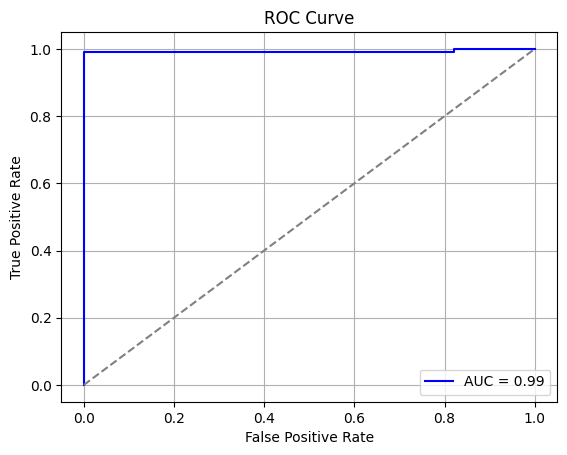


🧠 Author Attribution Accuracy: 1.00
📊 Classification Report:
               precision    recall  f1-score   support

     dataset       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

📉 Confusion Matrix:
 [[20]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
# ✅ STEP 0: Install libraries
!pip install transformers accelerate scikit-learn tqdm matplotlib --quiet

# ✅ STEP 1: Imports
import os, glob, time, json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaModel, pipeline

# ✅ STEP 2: Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
model.eval()

llm = pipeline("text-generation", model="tiiuae/falcon-rw-1b", device=-1)

# ✅ STEP 3: Read Java files
def load_java_files(base_path, max_files=100):
    java_files = glob.glob(base_path + "/**/*.java", recursive=True)
    code, authors = [], []
    for path in tqdm(java_files[:max_files], desc="📂 Reading Java files"):
        try:
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read().strip()
                if len(content) > 50:
                    code.append(content)
                    authors.append(os.path.basename(os.path.dirname(path)))
        except:
            continue
    return code, authors

# ✅ STEP 4: Obfuscation
def obfuscate_java_code(snippets):
    obf = []
    for code in tqdm(snippets, desc="🤖 Obfuscating"):
        prompt = f"""You are a code obfuscator. Rename vars, reorder blocks, add dead code. Keep logic.
Java Code:
{code[:400]}
Obfuscated Java Code:"""
        try:
            result = llm(prompt, max_new_tokens=100, do_sample=True, temperature=0.9)[0]['generated_text']
            obfuscated = result.split("Obfuscated Java Code:")[-1].strip()
        except:
            obfuscated = code
        obf.append(obfuscated)
    return obf

# ✅ STEP 5: Embeddings
@torch.no_grad()
def get_embeddings(snippets, batch_size=4, max_length=256):
    embs = []
    for i in tqdm(range(0, len(snippets), batch_size), desc="🔗 Embedding"):
        batch = snippets[i:i+batch_size]
        try:
            tokens = tokenizer(batch, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length).to(device)
            out = model(**tokens).last_hidden_state.mean(dim=1).cpu().numpy()
            embs.extend(out)
        except:
            continue
    return np.array(embs, dtype=np.float32)

# ✅ STEP 6: Beta-VAE
class BetaVAE(nn.Module):
    def __init__(self, input_dim=768, latent_dim=64, beta=4.0):
        super().__init__()
        self.beta = beta
        self.encoder = nn.Sequential(nn.Linear(input_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, input_dim))
    def reparam(self, mu, logvar):
        return mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparam(mu, logvar)
        return self.decoder(z), mu, logvar
    def compute_loss(self, x, recon, mu, logvar):
        mse = nn.functional.mse_loss(recon, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return mse + self.beta * kld

# ✅ STEP 7: Train VAE
def train_vae(X_embed, beta=4.0):
    vae = BetaVAE(input_dim=X_embed.shape[1], beta=beta).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    loader = torch.utils.data.DataLoader(torch.tensor(X_embed, dtype=torch.float32), batch_size=16, shuffle=True)
    vae.train()
    for epoch in range(5):
        total = 0
        for batch in loader:
            batch = batch.to(device)
            recon, mu, logvar = vae(batch)
            loss = vae.compute_loss(batch, recon, mu, logvar)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total += loss.item()
        print(f"📘 Epoch {epoch+1}: Loss {total:.2f}")
    return vae

# ✅ STEP 8: Feature Extraction
@torch.no_grad()
def extract_features(vae, X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    recon, mu, _ = vae(X_tensor)
    errors = ((X_tensor - recon)**2).mean(dim=1).cpu().numpy()
    return np.hstack([mu.cpu().numpy(), errors.reshape(-1, 1)]), errors

# ✅ STEP 9: Evaluate All
def evaluate_all(features, labels, errors, authors, embeddings):
    threshold = np.percentile(errors, 90)
    y_pred = (errors > threshold).astype(int)

    print(f"\n📈 Anomaly Threshold: {threshold:.4f}")
    print("📊 Anomaly Detection Report:\n", classification_report(labels, y_pred))
    print("📉 Confusion Matrix:\n", confusion_matrix(labels, y_pred))

    fpr, tpr, _ = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='blue')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title("ROC Curve"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.grid(True); plt.legend(); plt.show()

    # Authorship Attribution
    le = LabelEncoder()
    y = le.fit_transform(authors)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, stratify=y)
    clf = RandomForestClassifier(n_estimators=300)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(f"\n🧠 Author Attribution Accuracy: {accuracy_score(y_test, pred):.2f}")
    print("📊 Classification Report:\n", classification_report(y_test, pred, target_names=le.classes_))
    print("📉 Confusion Matrix:\n", confusion_matrix(y_test, pred))

# ✅ STEP 10: Run Full Pipeline
!unzip -q /content/GPT-Java-GCJ-Dataset-main.zip -d /content/java_data

code, authors = load_java_files("/content/java_data/GPT-Java-GCJ-Dataset-main", max_files=100)
obf_code = obfuscate_java_code(code)

X_clean = get_embeddings(code)
X_obf = get_embeddings(obf_code)

vae = train_vae(X_clean)
X_all = np.vstack([X_clean, X_obf])
y_bin = np.array([0]*len(X_clean) + [1]*len(X_obf))
features, errors = extract_features(vae, X_all)

evaluate_all(features, y_bin, errors, authors, X_clean)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.0 MB/s eta 0:00:00
🖥️ Device: CPU


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cpu

📂 Loading .java files: 100%|██████████| 100/100 [00:00<00:00, 4859.69it/s]

🤖 Obfuscating:   0%|          | 0/100 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

🤖 Obfuscating:   1%|          | 1/100 [01:52<3:05:15, 112.27s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

🤖 Obfuscating:   2%|▏         | 2/100 [03:30<2:49:47, 103.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

🤖 Obfuscating:   3%|▎         | 3/100 [05:22<2:54:03, 107.66s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

🤖 Obfuscating:   4%|▍         | 4/100 [07:06<2:49:51, 106.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

🤖 Obfuscating:   5%|▌         | 5/100 [08:46<2:44:27, 103.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

🤖 Obfuscating:   6%|▌         | 6/100 [10:20<2:37:27, 100.51s/it]Setting `pad_token_id` to `eos_token_id`:2 

📘 Epoch 1: Loss = 28458.51
📘 Epoch 2: Loss = 13989.10
📘 Epoch 3: Loss = 6809.70
📘 Epoch 4: Loss = 4174.24
📘 Epoch 5: Loss = 3077.53
📘 Epoch 6: Loss = 2271.95
📘 Epoch 7: Loss = 1835.46
📘 Epoch 8: Loss = 1509.39
📘 Epoch 9: Loss = 1398.32
📘 Epoch 10: Loss = 1402.12

📈 Optimal Anomaly Threshold: 0.0870 (Youden)
📊 Anomaly Detection Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200

📉 Confusion Matrix:
 [[100   0]
 [  1  99]]


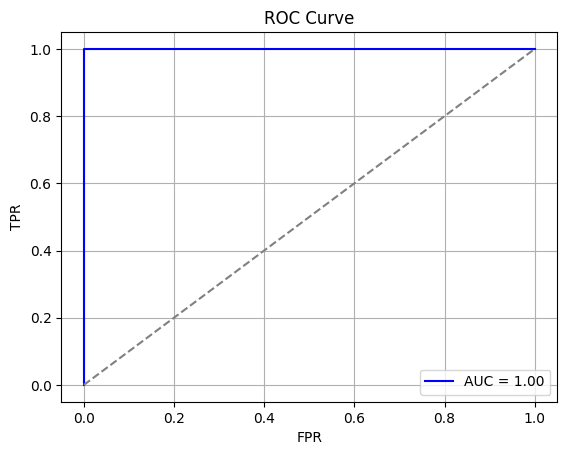


🧠 Author Attribution Accuracy: 1.00
📊 Classification Report:
               precision    recall  f1-score   support

     dataset       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

📉 Confusion Matrix:
 [[20]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
# ✅ STEP 0: Install libraries
!pip install transformers accelerate scikit-learn tqdm matplotlib --quiet

# ✅ STEP 1: Imports
import os, glob, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaModel, pipeline

# ✅ STEP 2: Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device).eval()
llm = pipeline("text-generation", model="tiiuae/falcon-rw-1b", device=-1)

# ✅ STEP 3: Load code
def load_java_files(base_path, max_files=100):
    files = glob.glob(base_path + "/**/*.java", recursive=True)
    code, authors = [], []
    for path in tqdm(files[:max_files], desc="📂 Loading .java files"):
        try:
            with open(path, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read().strip()
                if len(content) > 50:
                    code.append(content)
                    authors.append(os.path.basename(os.path.dirname(path)))
        except: continue
    return code, authors

# ✅ STEP 4: Obfuscation
def obfuscate_java_code(snippets):
    obf = []
    for code in tqdm(snippets, desc="🤖 Obfuscating"):
        prompt = f"You are a code obfuscator. Rename vars, reorder blocks, add dead code. Keep logic.\nJava Code:\n{code[:400]}\nObfuscated Java Code:"
        try:
            result = llm(prompt, max_new_tokens=100, do_sample=True, temperature=0.9)[0]["generated_text"]
            obfuscated = result.split("Obfuscated Java Code:")[-1].strip()
        except: obfuscated = code
        obf.append(obfuscated)
    return obf

# ✅ STEP 5: Embedding
@torch.no_grad()
def get_embeddings(snippets, batch_size=4, max_len=256):
    embs = []
    for i in tqdm(range(0, len(snippets), batch_size), desc="🔗 Embedding"):
        batch = snippets[i:i+batch_size]
        try:
            tokens = tokenizer(batch, return_tensors="pt", padding="max_length", truncation=True, max_length=max_len).to(device)
            output = model(**tokens).last_hidden_state.mean(dim=1).cpu().numpy()
            embs.extend(output)
        except: continue
    return np.array(embs, dtype=np.float32)

# ✅ STEP 6: VAE Class
class BetaVAE(nn.Module):
    def __init__(self, input_dim=768, latent_dim=64, beta=4.0):
        super().__init__()
        self.beta = beta
        self.encoder = nn.Sequential(nn.Linear(input_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, input_dim))

    def reparam(self, mu, logvar):
        return mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)

    def forward(self, x):
        enc = self.encoder(x)
        mu, logvar = self.mu(enc), self.logvar(enc)
        z = self.reparam(mu, logvar)
        return self.decoder(z), mu, logvar

    def loss_fn(self, x, recon, mu, logvar):
        mse = nn.functional.mse_loss(recon, x, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return mse + self.beta * kl

# ✅ STEP 7: Train VAE
def train_vae(X, beta=4.0, epochs=10):
    vae = BetaVAE(beta=beta).to(device)
    opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
    loader = torch.utils.data.DataLoader(torch.tensor(X, dtype=torch.float32), batch_size=16, shuffle=True)
    for epoch in range(epochs):
        total = 0
        for batch in loader:
            batch = batch.to(device)
            recon, mu, logvar = vae(batch)
            loss = vae.loss_fn(batch, recon, mu, logvar)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()
        print(f"📘 Epoch {epoch+1}: Loss = {total:.2f}")
    return vae

# ✅ STEP 8: Feature Extraction
@torch.no_grad()
def extract_features(vae, X):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    recon, mu, logvar = vae(X)
    err = ((X - recon)**2).mean(dim=1).cpu().numpy()
    return np.hstack([mu.cpu().numpy(), err.reshape(-1,1)]), err

# ✅ STEP 9: Evaluate
def evaluate_all(features, labels, errors, authors, embeddings):
    # 🔍 Anomaly Detection
    fpr, tpr, thresholds = roc_curve(labels, errors)
    best_idx = np.argmax(tpr - fpr)
    threshold = thresholds[best_idx]
    pred = (errors > threshold).astype(int)

    print(f"\n📈 Optimal Anomaly Threshold: {threshold:.4f} (Youden)")
    print("📊 Anomaly Detection Report:\n", classification_report(labels, pred))
    print("📉 Confusion Matrix:\n", confusion_matrix(labels, pred))

    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='blue')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.grid(True); plt.legend(); plt.show()

    # 🧠 Authorship Attribution
    le = LabelEncoder()
    y = le.fit_transform(authors)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, stratify=y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=300).fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"\n🧠 Author Attribution Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    print("📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ✅ STEP 10: Run Pipeline
!unzip -q /content/GPT-Java-GCJ-Dataset-main.zip -d /content/java_data

code, authors = load_java_files("/content/java_data/GPT-Java-GCJ-Dataset-main", max_files=100)
obf_code = obfuscate_java_code(code)

X_clean = get_embeddings(code)
X_obf = get_embeddings(obf_code)

# Dual-VAE Setup
beta_vae = train_vae(X_clean, beta=4.0, epochs=10)
features, errors = extract_features(beta_vae, np.vstack([X_clean, X_obf]))
labels = np.array([0]*len(X_clean) + [1]*len(X_obf))

evaluate_all(features, labels, errors, authors, X_clean)


In [ ]:
# ✅ STEP 0: Install libraries
!pip install transformers accelerate scikit-learn tqdm matplotlib pandas --quiet

# ✅ STEP 1: Imports
import os, time, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaModel, pipeline
from google.colab import drive
drive.mount('/content/drive')

# ✅ STEP 2: Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# ✅ STEP 3: Load models
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
codebert = RobertaModel.from_pretrained("microsoft/codebert-base").to(device).eval()
llm = pipeline("text-generation", model="tiiuae/falcon-rw-1b", device=-1)

# ✅ STEP 4: Load multilingual code from GCJ-style CSVs
def load_code_from_csvs(folder_path, max_per_file=100):
    code, authors = [], []
    for file in glob.glob(f"{folder_path}/*.csv"):
        df = pd.read_csv(file)
        df = df[df["flines"].notna() & df["full_path"].notna()]
        for _, row in df.iterrows():
            path = str(row["full_path"])
            snippet = str(row["flines"]).strip()
            author = os.path.basename(path.strip().split("/")[0])
            if len(snippet) > 50:
                code.append(snippet)
                authors.append(author)
                if len(code) >= max_per_file * len(glob.glob(f"{folder_path}/*.csv")):
                    break
    return code, authors

# ✅ STEP 5: Falcon-RW-1B LLM-based obfuscation
def obfuscate_code(codes):
    obf = []
    for c in tqdm(codes, desc="Obfuscating"):
        prompt = f"You are a code obfuscator. Rename vars, reorder blocks, add dead code. Keep logic.\nJava Code:\n{c[:200]}\nObfuscated Java Code:"
        try:
            result = llm(prompt, max_new_tokens=200, do_sample=True, temperature=0.9)[0]['generated_text']
            obf_code = result.split("Obfuscated Java Code:")[-1].strip()
        except:
            obf_code = c
        obf.append(obf_code)
    return obf

# ✅ STEP 6: CodeBERT Embeddings
@torch.no_grad()
def get_embeddings(snippets, batch_size=4, max_len=256):
    embs = []
    for i in tqdm(range(0, len(snippets), batch_size), desc="Embedding"):
        batch = snippets[i:i+batch_size]
        try:
            tokens = tokenizer(batch, return_tensors="pt", padding="max_length", truncation=True, max_length=max_len).to(device)
            output = codebert(**tokens).last_hidden_state.mean(dim=1).cpu().numpy()
            embs.extend(output)
        except: continue
    return np.array(embs, dtype=np.float32)

# ✅ STEP 7: Beta-VAE
class BetaVAE(nn.Module):
    def __init__(self, input_dim=768, latent_dim=64, beta=4.0):
        super().__init__()
        self.beta = beta
        self.encoder = nn.Sequential(nn.Linear(input_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU())
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, input_dim))
    def reparam(self, mu, logvar):
        return mu + torch.randn_like(logvar) * torch.exp(0.5 * logvar)
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparam(mu, logvar)
        return self.decoder(z), mu, logvar
    def loss_fn(self, x, recon, mu, logvar):
        mse = nn.functional.mse_loss(recon, x, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return mse + self.beta * kl

def train_vae(X, beta=4.0, epochs=10):
    vae = BetaVAE(beta=beta).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    loader = torch.utils.data.DataLoader(torch.tensor(X, dtype=torch.float32), batch_size=16, shuffle=True)
    for ep in range(epochs):
        total = 0
        for batch in loader:
            batch = batch.to(device)
            recon, mu, logvar = vae(batch)
            loss = vae.loss_fn(batch, recon, mu, logvar)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total += loss.item()
        print(f"Epoch {ep+1}, Loss: {total:.2f}")
    return vae

# ✅ STEP 8: Extract features
@torch.no_grad()
def extract_features(vae, X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    recon, mu, _ = vae(X_tensor)
    errors = ((X_tensor - recon)**2).mean(dim=1).cpu().numpy()
    return np.hstack([mu.cpu().numpy(), errors.reshape(-1,1)]), errors

# ✅ STEP 9: Evaluation
def evaluate_all(features, labels, errors, authors, embeddings):
    fpr, tpr, thresholds = roc_curve(labels, errors)
    best_idx = np.argmax(tpr - fpr)
    threshold = thresholds[best_idx]
    pred = (errors > threshold).astype(int)

    print(f"\nAnomaly Detection (Threshold={threshold:.4f}):")
    print(classification_report(labels, pred))
    print("Confusion Matrix:\n", confusion_matrix(labels, pred))

    auc_score = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='blue')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # Authorship Attribution
    le = LabelEncoder()
    y = le.fit_transform(authors)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, y, stratify=y, test_size=0.2)
    clf = RandomForestClassifier(n_estimators=300, max_depth=20)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("\nAuthor Attribution:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ✅ STEP 10: Run Full Pipeline
csv_folder = "/content/drive/MyDrive/Dataset1"  # Your folder with gcj2017.csv etc.

code, authors = load_code_from_csvs(csv_folder, max_per_file=100)
obf_code = obfuscate_code(code)

X_clean = get_embeddings(code)
X_obf = get_embeddings(obf_code)

vae_clean = train_vae(X_clean, beta=4.0, epochs=10)
X_all = np.vstack([X_clean, X_obf])
y_bin = np.array([0]*len(X_clean) + [1]*len(X_obf))

features, errors = extract_features(vae_clean, X_all)
evaluate_all(features, y_bin, errors, authors, X_clean)


Mounted at /content/drive
Device: CPU


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cpu
/tmp/ipython-input-3-3991274714.py:33: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipython-input-3-3991274714.py:33: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
Obfuscating:  15%|█▍        | 59/401 [1:00:17<7:21:50, 77.52s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
